# 1. Tutorial: From Materials Project to Band Gap Prediction

In this tutorial, we begin with a brief introduction to **Materials Project**, a widely used open database for computational materials science. Taking Li-NASICON structures as an example, we demonstrate how to query and retrieve crystal structure data through the **MP-API**. After collecting the data, we perform feature engineering to extract meaningful descriptors. Finally, we build and train a machine learning model to predict the band gap of the collected materials.

## [1.1 Materials Project](https://next-gen.materialsproject.org/)

<center>
  <img src="Materials_Project.png" alt="Screenshot of MP" width="1000">
</center>

### 1.1.1 Open Materials Database
Materials Project is an open, online platform designed to accelerate materials discovery through data sharing and analysis. It provides standardized materials data to the research community, eliminating the need for each group to run their own costly first-principles calculations.

### 1.1.2 High-Throughput DFT Calculations
All data are generated using high-throughput density functional theory (DFT) calculations with VASP under consistent computational settings. Key properties include:
- Structural: lattice constants, atomic coordinates, space group
- Thermodynamic: formation energy, energy above hull, phase stability
- Electronic: band gap, density of states (DOS)
- Mechanical: bulk modulus, shear modulus, elastic tensors

### 1.1.3 Large-Scale Materials Data
- The Materials Project currently contains over 200,000 inorganic crystal structures and continues to grow.
- It covers a wide range of elements and compound systems across the periodic table.
- Includes not only pristine structures but also data on alloys, defects, dopants, and interfaces.


### 1.1.4 How to Access Data
There are two main ways to obtain data from the Materials Project:
- **Manual search and download** from [Materials Project](https://next-gen.materialsproject.org/) 
- **Application Programming Interface ([API](https://next-gen.materialsproject.org/api))**
    - Programmatic access to database
    - Retrieve structured data automatically (e.g., CIF)
    - Efficient for collecting large datasets.
    - Easy integration with Machine Learning / data analysis pipelines


-----------------------------------------------------
Up to this point, we have briefly introduced the Materials Project and discussed how to access its data.
Next, we will learn how to use Python to extract data from Materials Project through the **MP-API** and build a simple machine learning model using XGBoost to predict the band gap.

-----------------------------------------------------

## 1.2 Practical: Retrieving Data from Materials Project Using MP-API

In [1]:
# !pip install mp_api seaborn numpy pandas pymatgen matplotlib py3Dmol

Before we get started, we first need to import the required Python libraries using the **import** command. If a library is not installed, you can install it with the **pip install** command.

### 1.2.1 Import necessary libraries

- [**OS**](https://docs.python.org/3/library/os.html) —— Operating System
    - Let Python interact with your computer’s operating system
        - Manage files and folders
        - Work with file paths
        - Run system commands
        - Access environment variables


----------------------------------------------------
- [**Pandas**](https://pandas.pydata.org/) —— Data Processing & Analysis
    - Handle tabular data (like Excel,csv)
    - Very useful for cleaning, transforming, and analyzing datasets.
  
```python
import pandas as pd
df = pd.read_csv("data.csv")
print(df.head())  # Print first 5 rows in the csv file

----------------------------------------------------------------------------------------------
- [**Numpy**](https://numpy.org/) —— Numerical Computing
    - 	Provide fast mathematical operations on arrays and matrices.

In [31]:
import numpy as np
arr = np.array([1, 2, 3, 4]) # create an array
print(np.mean(arr))   # calculate mean
print(np.std(arr))    #calculate standard deviation

2.5
1.118033988749895


----------------------------------------------------
- [**Matplotlib**](https://matplotlib.org/)
    - fundamental plotting library in Python, used to create and control various types of figures.
    - Used to create and control various types of figures


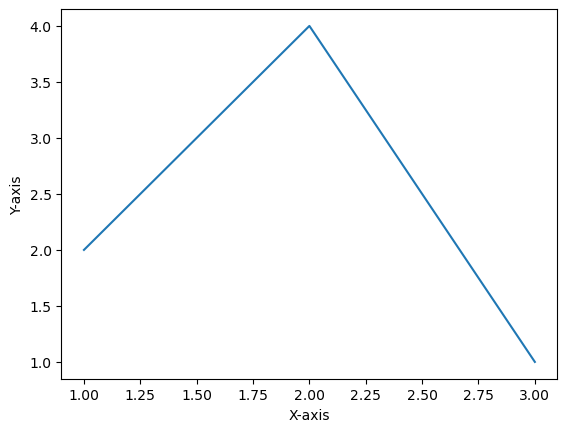

In [3]:
import matplotlib.pyplot as plt
x = [1, 2, 3]
y = [2, 4, 1]
plt.plot(x, y)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


----------------------------------------------------
- [**Seaborn**](https://seaborn.pydata.org/)
    - High-level visualization library built on top of Matplotlib
    - Provide more statistical plot types and cleaner, more attractive figures，such as heatmap

<center>
  <img src="seaborn.png" alt="Screenshot of Matplotlib" width="1000">
</center>

---------------------------------------------------
- [**Pymatgen**](https://pymatgen.org/)
    - A powerful library for crystal structure manipulation and analysis.
    - Can read / write CIF files, get element properties, and analyze structures.



In [4]:
from pymatgen.core import Element
from pymatgen.io.cif import CifWriter
from pymatgen.core import Structure

print(Element("Li").atomic_mass)  # element property
# Save structure as CIF
# CifWriter(structure).write_file("structure.cif")

6.941 amu


----------------------------------------------------
- [**Re**](https://docs.python.org/3/library/re.html) (Regular expression operations)

    - let Python search, match, and manipulate text using patterns.

```python
import re

text = "My phone number is 123-456-7890."
result = re.findall(r"\d+", text) # \d means digit, \d+ means match one or more digits
print(result)
```
['123', '456', '7890']

- [**MP-API**](https://next-gen.materialsproject.org/api)
    - The offical API of Materials project
    - An API key is needed, which can be found on [here](https://next-gen.materialsproject.org/api) 
- [**Optimade**](https://www.optimade.org/index)
    - A standardized API to extract data from multiple materials databases (e.g., Materials Project, Open Quantum Materials Database, AFLOW).
    - Enables cross-platform access and data integration.
    - For Materials Project, only a subset of structure and property data is shared.

In [5]:
# Step 1. Import Necessary library
import os
import numpy as np
import pandas as pd
from pymatgen.io.cif import CifWriter
from pymatgen.core import Structure
import seaborn as sns
import matplotlib.pyplot as plt
from pymatgen.core import Element
from mp_api.client import MPRester
import re

In [6]:
# Step 2. Set API key and use 
API_KEY = "likLRTvsX3F39qRPSYUwSDhRKgbf8Joz"
mpr = MPRester(API_KEY,mute_progress_bars=True)
print(mpr.materials.summary.available_fields)

['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'property_name', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'bulk_modulus', 'shear_modulus', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic',

### 1.2.2 Use API to search Li-NASICON Structures

We already imported the necessary libraries and set up the API key for accessing Materials Project. Next, we will use the API to search the database for a specific example: **Li-NASICON structured materials**.


**NASICON** is a widely studied structure type in battery materials.
- General formula: $A_xM_2(XO_4)_3$
    - A = alkali metal (e.g., Li, Na, K)
    - M = transition metal 
    - X = P or Si

- **Li-based NASICON materials** have been widely studied.
    - Example: $Li_{1.3}Al_{0.3}Ti_{1.7}(PO_4)_3$ (LATP), a solid electrolyte with high ionic conductivity.

Here, we will use the Materials Project API to search for Li-NASICON structures

In [7]:
M_list = ["Bi","Co","Cr","Fe","Ge","In","Mn","Nb","Ni","Sb","Sc","Ti","V","Zr"]
hits = []

#### First, search all Li–M–P–O compositions without any stoichiometric filtering.

In [8]:
for M in M_list:
    print(f"Searching for Li–{M}–P–O system (4 elements)...")
    results = mpr.materials.summary.search(
        chemsys=[f"Li-{M}-P-O"],
        num_elements=4,
        fields=[
            "material_id",
            "formula_pretty",
            "composition_reduced",
            "nsites",
            "volume",
            "density",
            "density_atomic",
            "symmetry",
            "formation_energy_per_atom",
            "energy_above_hull",
            "band_gap"
        ]
    )
    print(f"Found: {len(results)}")

    for r in results:
        sym = r.symmetry
        spacegroup_symbol = sym.symbol if sym else "N/A"
        spacegroup_number = sym.number if sym else "N/A"
        crystal_system = sym.crystal_system if sym else "N/A"

        hits.append({
            "material_id": r.material_id,
            "original_formula": r.formula_pretty,
            "M_element": M,
            "composition_reduced": r.composition_reduced,
            "nsites": r.nsites,
            "volume": r.volume,
            "density": r.density,
            "density_atomic": r.density_atomic,
            "spacegroup_symbol": spacegroup_symbol,
            "spacegroup_number": spacegroup_number,
            "crystal_system": crystal_system,
            "formation_energy_per_atom": r.formation_energy_per_atom,
            "energy_above_hull": r.energy_above_hull,
            "band_gap": r.band_gap
        })

print(f"Total Li–M–P–O structures collected: {len(hits)}")

Searching for Li–Bi–P–O system (4 elements)...
Found: 81
Searching for Li–Co–P–O system (4 elements)...
Found: 195
Searching for Li–Cr–P–O system (4 elements)...
Found: 263
Searching for Li–Fe–P–O system (4 elements)...
Found: 382
Searching for Li–Ge–P–O system (4 elements)...
Found: 5
Searching for Li–In–P–O system (4 elements)...
Found: 4
Searching for Li–Mn–P–O system (4 elements)...
Found: 455
Searching for Li–Nb–P–O system (4 elements)...
Found: 37
Searching for Li–Ni–P–O system (4 elements)...
Found: 221
Searching for Li–Sb–P–O system (4 elements)...
Found: 74
Searching for Li–Sc–P–O system (4 elements)...
Found: 4
Searching for Li–Ti–P–O system (4 elements)...
Found: 75
Searching for Li–V–P–O system (4 elements)...
Found: 670
Searching for Li–Zr–P–O system (4 elements)...
Found: 9
Total Li–M–P–O structures collected: 2475


#### In this step, We apply stoichiometric filtering to Li–M–P–O systems (LixM2P3O12)

In [9]:
# === Step 2: Filter by NASICON stoichiometry LixM2P3O12 
filtered_hits = []

for item in hits:
    comp = item["composition_reduced"]
    M = item["M_element"]

    li_count = int(comp.get("Li", 0))
    m_count  = int(comp.get(M, 0))
    p_count  = int(comp.get("P", 0))
    o_count  = int(comp.get("O", 0))
    total_atoms = li_count+m_count+p_count+o_count

    if 1 <= li_count <= 5 and m_count == 2 and p_count == 3 and o_count == 12:
        item["Li_count"] = li_count
        filtered_hits.append(item)

##### Print first 10 materials' information, including the mp-id, chemical fomula, number of atoms(nsites) and crystal systems

In [10]:
for item in filtered_hits[:10]: 
    print(
        f"{item['material_id']:15} | "
        f"{item['original_formula']:20} | "
        f"nsites={item['nsites']:<4} | "
        f"{item['crystal_system']}"
    )
print(f"\nTotal structures matching LixM2P3O12: {len(filtered_hits)}")

mp-25929        | Li3Bi2(PO4)3         | nsites=40   | Trigonal
mp-27069        | Li3Bi2(PO4)3         | nsites=80   | Monoclinic
mp-684042       | Li3Bi2(PO4)3         | nsites=40   | Monoclinic
mp-684504       | Li3Bi2(PO4)3         | nsites=80   | Monoclinic
mp-759290       | Li3Bi2(PO4)3         | nsites=40   | Monoclinic
mp-759381       | Li3Bi2(PO4)3         | nsites=40   | Monoclinic
mp-759390       | Li3Bi2(PO4)3         | nsites=80   | Monoclinic
mp-759734       | Li3Bi2(PO4)3         | nsites=80   | Monoclinic
mp-780333       | Li3Bi2(PO4)3         | nsites=80   | Monoclinic
mp-26285        | LiBi2(PO4)3          | nsites=72   | Monoclinic

Total structures matching LixM2P3O12: 263


### 1.2.3 Save the structure information into csv and cif file

In [11]:
import pandas as pd

df = pd.DataFrame(filtered_hits)
df.to_csv("Li_NASICON.csv", index=False)
print(f"Saved {len(df)} entries to Li_NASICON.csv")
df.head() # 

Saved 263 entries to Li_NASICON.csv


,material_id,original_formula,M_element,composition_reduced,nsites,volume,density,density_atomic,spacegroup_symbol,spacegroup_number,crystal_system,formation_energy_per_atom,energy_above_hull,band_gap,Li_count
0,mp-25929,Li3Bi2(PO4)3,Bi,"(Li, Bi, P, O)",40,571.832834,4.203077,14.295821,R-3,148,Trigonal,-2.509939,0.039917,3.7574,3
1,mp-27069,Li3Bi2(PO4)3,Bi,"(Li, Bi, P, O)",80,1080.627352,4.448263,13.507842,P2_1/c,14,Monoclinic,-2.510778,0.039078,4.0926,3
2,mp-684042,Li3Bi2(PO4)3,Bi,"(Li, Bi, P, O)",40,555.706152,4.325051,13.892654,C2/c,15,Monoclinic,-2.501185,0.048671,4.0260,3
3,mp-684504,Li3Bi2(PO4)3,Bi,"(Li, Bi, P, O)",80,1136.620402,4.229129,14.207755,P2_1/c,14,Monoclinic,-2.512524,0.037332,4.0294,3
4,mp-759290,Li3Bi2(PO4)3,Bi,"(Li, Bi, P, O)",40,549.801855,4.371497,13.745046,C2/c,15,Monoclinic,-2.466169,0.083687,3.6043,3


In [12]:
# === Step 4: Download CIF files for filtered structures ===
import os
from pymatgen.io.cif import CifWriter

OUT_DIR = "./NASICON_CIFs"
os.makedirs(OUT_DIR, exist_ok=True)

for h in filtered_hits:
    mid = h["material_id"]
    structure = mpr.materials.get_structure_by_material_id(mid)
    cif_path = os.path.join(OUT_DIR, f"{mid}_{h['original_formula']}.cif")
    CifWriter(structure).write_file(cif_path)

print(f"Saved {len(filtered_hits)} CIF files to {OUT_DIR}")

Saved 263 CIF files to ./NASICON_CIFs


### 1.2.4 Visualize one structure using py3Dmol

- A Python library that can visualize molecular and crystal structures in 3D.

In [33]:
import os
from pymatgen.core import Element, Structure
import py3Dmol

# === List CIF files ===
cif_files = [f for f in os.listdir(OUT_DIR) if f.endswith(".cif")]

# === Load one structure as an example ===
example_file = os.path.join(OUT_DIR, cif_files[50])
s = Structure.from_file(example_file)

# === Extract unique elements ===
elements = sorted(set(str(site.specie) for site in s.sites))

# === Define colors (fixed for Li, P, O; assign default color for others) ===
color_map = {"Li": "green", "P": "orange", "O": "red"}
default_color = "blue"
for elem in elements:
    if elem not in color_map:
        color_map[elem] = default_color

# === Visualization with py3Dmol ===
view = py3Dmol.view(width=600, height=600)
view.addModel(s.to(fmt="cif"), "cif")

# Use realistic atomic radius for sphere size
for elem in elements:
    radius = Element(elem).atomic_radius or 1.0
    view.setStyle({"elem": elem}, {"sphere": {"color": color_map[elem], "radius": radius}})

view.addUnitCell()
view.zoomTo()
view.show()

# === Print legend ===
print("Color Legend (element : color | atomic radius in Å):")
for elem in elements:
    r = round(Element(elem).atomic_radius or 1.0, 2)
    print(f"  {elem:>2} : {color_map[elem]}  (radius = {r} Å)")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Color Legend (element : color | atomic radius in Å):
  Cr : blue  (radius = 1.4 Å)
  Li : green  (radius = 1.45 Å)
   O : red  (radius = 0.6 Å)
   P : orange  (radius = 1.0 Å)


### 1.2.5 Feature Engineering

- Add simple **composition features** to enrich the dataset.  
- Basic **elemental information** of each material.  
  - Mass fraction of each element
  - Average electronegativity
  - Average atomic radius
- Details information about **lattice parameters**
    - a,b,c $\alpha$, $\beta$, $\gamma$ 

In [14]:
comp_features = []

for h in filtered_hits:
    mid = h["material_id"]
    comp = h["composition_reduced"]
    M = h["M_element"]

    # --- 1. Lattice parameter ---
    try:
        structure = mpr.get_structure_by_material_id(mid)
        lattice = structure.lattice
        a, b, c = lattice.a, lattice.b, lattice.c
        alpha, beta, gamma = lattice.alpha, lattice.beta, lattice.gamma
    except Exception as e:
        print(f"❌ Failed to get structure for {mid}: {e}")
        a = b = c = alpha = beta = gamma = None

    # --- 2. Mass fractions and averages ---

    li_count = float(comp.get("Li", 0))
    m_count  = float(comp.get(M, 0))
    p_count  = float(comp.get("P", 0))
    o_count  = float(comp.get("O", 0))
    total_atoms = li_count + m_count + p_count + o_count
    
    total_mass = total_elec_neg = total_radius = 0.0
    for el, num in comp.items():
        E = Element(el)
        total_mass += E.atomic_mass * num
        total_elec_neg += (E.X or 0) * num
        total_radius += (E.atomic_radius or 0) * num

    li_mass_frac = (Element("Li").atomic_mass * li_count) / total_mass if total_mass else 0
    p_mass_frac  = (Element("P").atomic_mass * p_count) / total_mass if total_mass else 0
    o_mass_frac  = (Element("O").atomic_mass * o_count) / total_mass if total_mass else 0
    m_mass_frac  = 1 - li_mass_frac - p_mass_frac - o_mass_frac

    mean_elec_neg = total_elec_neg / total_atoms if total_atoms else 0
    mean_radius = total_radius / total_atoms if total_atoms else 0

    # --- 3. Append features ---
    comp_features.append({
        "material_id": mid,
        "a": a,
        "b": b,
        "c": c,
        "alpha": alpha,
        "beta": beta,
        "gamma": gamma,
        "Li_mass_frac": li_mass_frac,
        "P_mass_frac": p_mass_frac,
        "O_mass_frac": o_mass_frac,
        "M_mass_frac": m_mass_frac,
        "total_elec_neg": total_elec_neg,
        "mean_radius": mean_radius
    })

print(f"Extracted features for {len(comp_features)} structures.")

Extracted features for 263 structures.


In [15]:
comp_df = pd.DataFrame(comp_features)
df_old = pd.read_csv("Li_NASICON.csv")

# Combine dataframe align with Material_id
df_new = df_old.merge(comp_df, on="material_id", how="left")
df_new.to_csv("Li_NASICON_all.csv", index=False)
df_new.head()

,material_id,original_formula,M_element,composition_reduced,nsites,volume,density,density_atomic,spacegroup_symbol,spacegroup_number,...,c,alpha,beta,gamma,Li_mass_frac,P_mass_frac,O_mass_frac,M_mass_frac,total_elec_neg,mean_radius
0,mp-25929,Li3Bi2(PO4)3,Bi,Li3 Bi2 P3 O12,40,571.832834,4.203077,14.295821,R-3,148,...,9.756358,54.459216,54.459216,54.459220,0.028773,0.128398,0.265294,0.577535,54.83,0.8875
1,mp-27069,Li3Bi2(PO4)3,Bi,Li3 Bi2 P3 O12,80,1080.627352,4.448263,13.507842,P2_1/c,14,...,15.563778,56.681068,90.000000,90.000000,0.028773,0.128398,0.265294,0.577535,54.83,0.8875
2,mp-684042,Li3Bi2(PO4)3,Bi,Li3 Bi2 P3 O12,40,555.706152,4.325051,13.892654,C2/c,15,...,9.254020,63.641119,63.641119,63.325939,0.028773,0.128398,0.265294,0.577535,54.83,0.8875
3,mp-684504,Li3Bi2(PO4)3,Bi,Li3 Bi2 P3 O12,80,1136.620402,4.229129,14.207755,P2_1/c,14,...,16.035767,56.326829,90.000000,90.000000,0.028773,0.128398,0.265294,0.577535,54.83,0.8875
4,mp-759290,Li3Bi2(PO4)3,Bi,Li3 Bi2 P3 O12,40,549.801855,4.371497,13.745046,C2/c,15,...,8.876968,63.294954,63.294954,63.643773,0.028773,0.128398,0.265294,0.577535,54.83,0.8875


### 1.2.6 Feature Visualization

We use two common methods to show **relationships between features**:

---

#### Pearson Correlation Coefficient

$$
r_{XY} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

- Cov(X, Y) is the **covariance** between X and Y  
- $\sigma_X$ is the **standard deviation**  
- $r \in [-1, 1]$:  
  - $r > 0$ → positive correlation  
  - $r < 0$ → negative correlation  
  - $r \approx 0$ → weak or no linear correlation

Pearson only captures **linear** relationships.

In [16]:
num_df = df_new.select_dtypes(include=['float64', 'int64'])
corr = num_df.corr()
print("Corr Shape:", corr.shape)

Corr Shape: (21, 21)


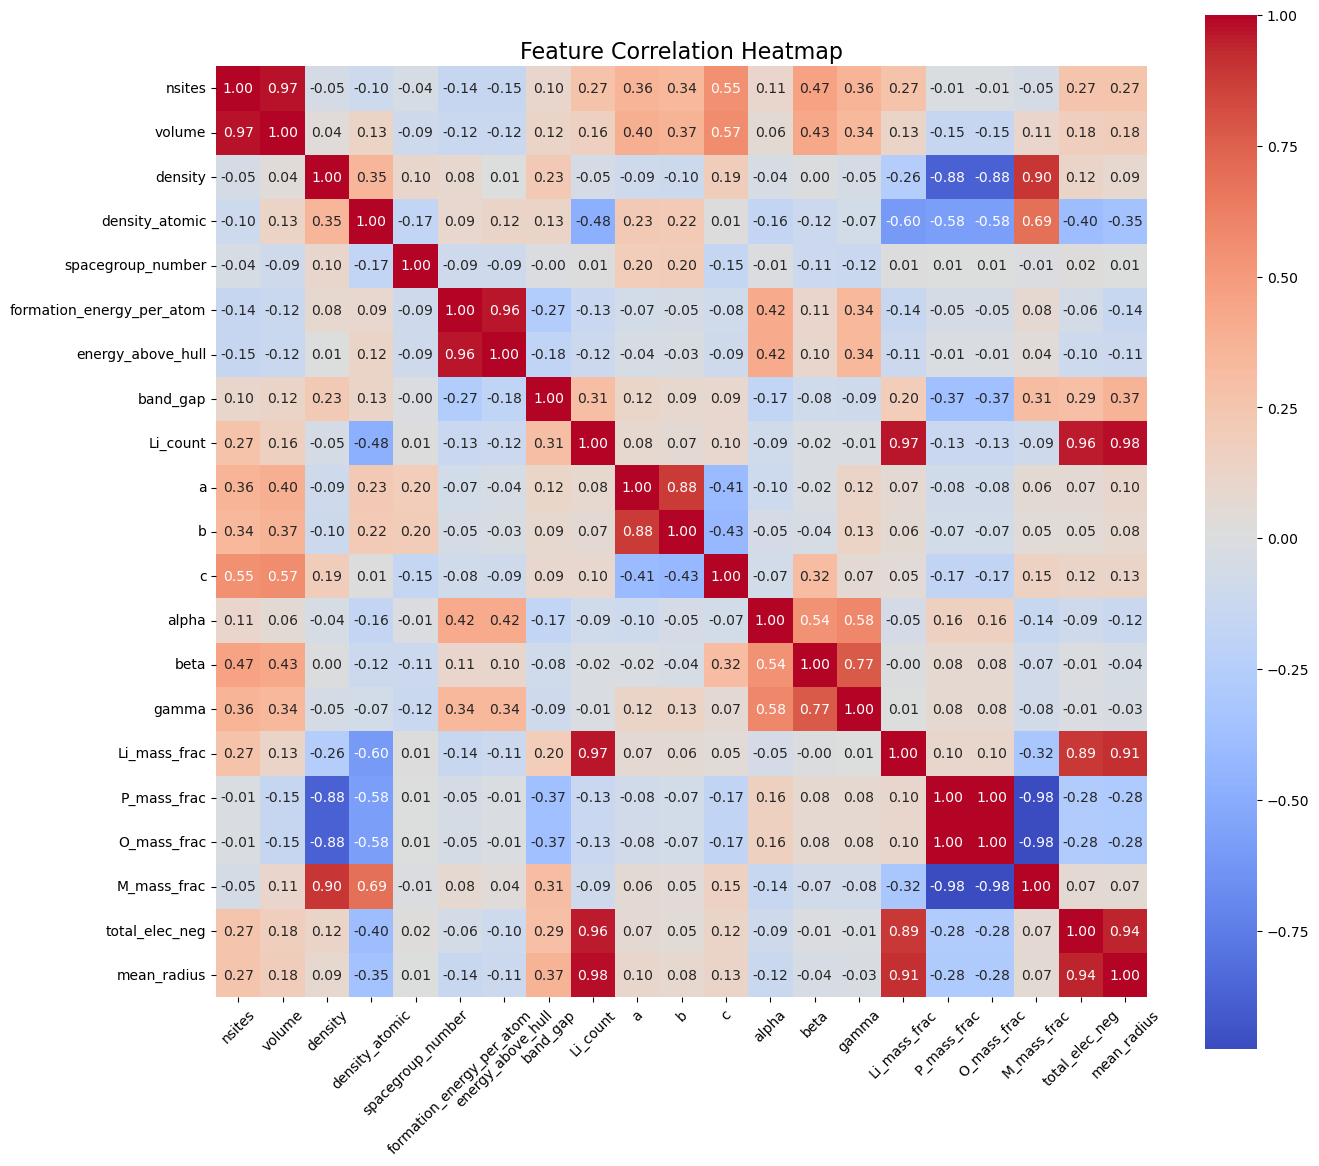

In [17]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.xticks(rotation=45)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()

plt.show()

#### Mutual Information


$$
I(X; Y) = \iint p(x, y)\,\log \frac{p(x, y)}{p(x)p(y)}\,dx\,dy
$$

- $p(x, y)$ = joint probability density of $X$ and $Y$  
- $p(x)$, $p(y)$ = marginal densities of $X$ and $Y$  
- $I(X; Y) = 0$ if and only if $X$ and $Y$ are independent  
- Larger values = stronger dependence (linear or non-linear)

Mutual information can capture **both linear and non-linear** relationships.

In [18]:
from sklearn.feature_selection import mutual_info_regression

cols = num_df.columns
n = len(cols)
mi_matrix = np.zeros((n, n))

In [19]:
# Compute MI between each pair (i, j)
for i in range(n):
    for j in range(n):
        if i != j:
            X = num_df[[cols[i]]]
            y = num_df[cols[j]]
            mi_matrix[i, j] = mutual_info_regression(X, y, random_state=42)[0]
        else:
            mi_matrix[i, j] = np.nan  

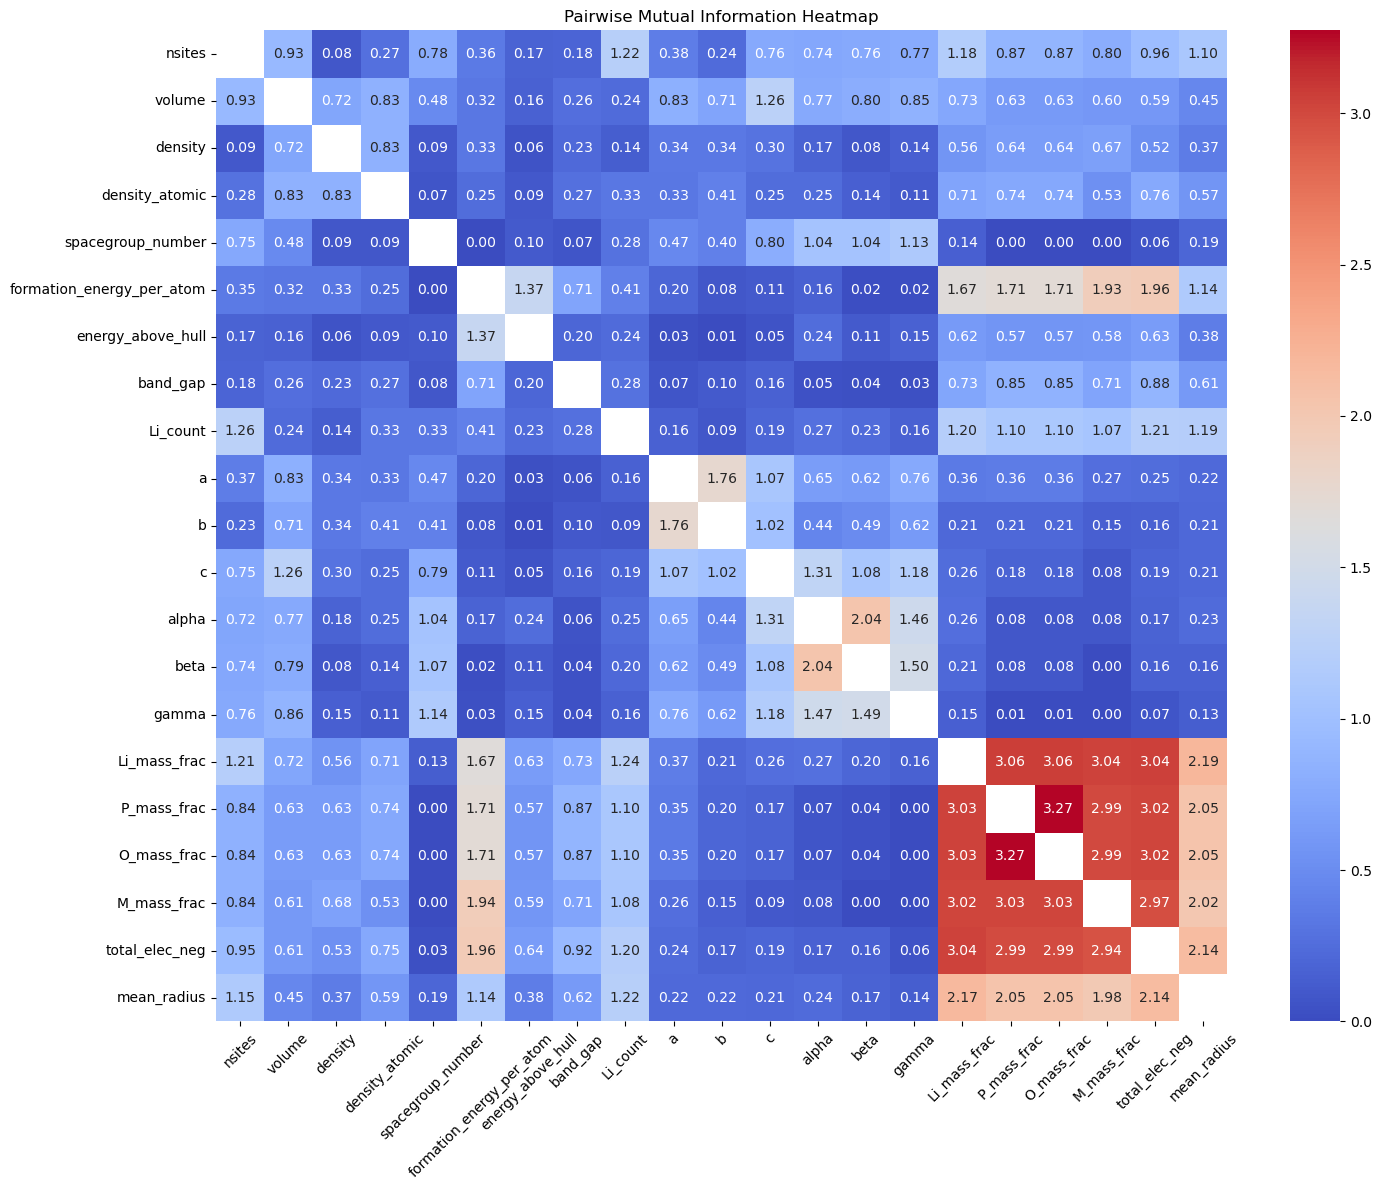

In [20]:
# Convert to DataFrame
mi_df = pd.DataFrame(mi_matrix, index=cols, columns=cols)

# Plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(mi_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pairwise Mutual Information Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.2.7 Machine Learning Prediction

- Here we use **XGBoost** to build a simple classification model to predict the **band gap class** of NASICON materials:
  - $E_g < 0.1$ eV → **Conductor**
  - $0.1 \leq E_g < 2$ eV → **Semiconductor**
  - $E_g \geq 2$ eV → **Insulator**

<br>

- **XGBoost** (Extreme Gradient Boosting) is a fast and powerful tree-based machine learning algorithm.
  - Based on **gradient boosting** decision trees.
  - Handles both numerical and categorical features.
  - Works well on small to medium datasets.
  - Widely used in competitions and real applications because of its accuracy and efficiency.

<br>

- For training, we selected features with **mutual information (MI) ≥ 0.2** to keep only the most relevant predictors.
- Among elemental mass fraction features, only **O\_mass\_frac** was kept to reduce redundancy and avoid strong collinearity.
- These selected features are then used to train and evaluate the XGBoost classification model.

In [21]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

# 1. Load the previously saved full feature file
df_full = pd.read_csv("Li_NASICON_all.csv")
target = "band_gap"

# 2. Select only numerical columns
num_df = df_full.select_dtypes(include=[np.number])

In [22]:
# 3. Compute Mutual Information between target and other features
X = num_df.drop(columns=[target])
y = num_df[target]
mi = mutual_info_regression(X, y, random_state=42)

# 4. Convert MI result to a Series
mi_series = pd.Series(mi, index=X.columns)

In [23]:
# 5. Filter features with MI ≥ 0.2
threshold = 0.2
selected_features = mi_series[mi_series >= threshold].index.tolist()

# 6. Manually exclude some features
exclude_features = ["Li_mass_frac", "P_mass_frac", "M_mass_frac"]
selected_features = [f for f in selected_features if f not in exclude_features]

print(f"Selected features with MI ≥ {threshold}, after exclusion:")
for feat in selected_features:
    print(f"{feat:25}  MI = {mi_series[feat]:.3f}")

Selected features with MI ≥ 0.2, after exclusion:
volume                     MI = 0.259
density                    MI = 0.226
density_atomic             MI = 0.274
formation_energy_per_atom  MI = 0.716
energy_above_hull          MI = 0.202
Li_count                   MI = 0.289
O_mass_frac                MI = 0.864
total_elec_neg             MI = 0.902
mean_radius                MI = 0.652


In [24]:
# 7. Create a new DataFrame with selected features + target
df_selected = df_full[selected_features + [target]]
df_selected.to_csv('nasicon_selected_features.csv')
print(f"Saved filtered features: {len(selected_features)} features + target")

Saved filtered features: 9 features + target


In [25]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# ========== 1. Load selected features ==========
df = pd.read_csv("nasicon_selected_features.csv")

# ========== 2. Define classes ==========
def classify_gap(gap):
    if gap <= 0.1:
        return 0  # Metal
    elif gap <= 2.0:
        return 1  # Semiconductor
    else:
        return 2  # Insulator

y = df["band_gap"].apply(classify_gap)
X = df.drop(columns=["band_gap"])

# View category distribution
print("Class distribution:")
print(y.value_counts().rename({0: "Metal", 1: "Semiconductor", 2: "Insulator"}))

Class distribution:
band_gap
Metal            94
Insulator        91
Semiconductor    78
Name: count, dtype: int64


In [26]:
#  3. Split training, validation, test dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
)

print(f" Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


 Train: 183, Val: 27, Test: 53


In [27]:
#  4. XGBoost Classifier
clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric="mlogloss"
)


In [28]:
#  5. Cross Validation 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring="accuracy")
print(f"10-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 6. Train 
clf.fit(X_train, y_train)

10-Fold CV Accuracy: 0.6763 ± 0.0909


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [29]:
# 7. Evaluation
def evaluate_multiclass(y_true, y_pred, set_name="Set"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    print(f"{set_name:<12} ACC={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")
    return acc, prec, rec, f1

y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)

print("\n Classification performance with XGBoost:")
evaluate_multiclass(y_train, y_pred_train, "Training")
evaluate_multiclass(y_val, y_pred_val, "Validation")
evaluate_multiclass(y_test, y_pred_test, "Test")


 Classification performance with XGBoost:
Training     ACC=1.0000 | Precision=1.0000 | Recall=1.0000 | F1=1.0000
Validation   ACC=0.7407 | Precision=0.7585 | Recall=0.7417 | F1=0.7330
Test         ACC=0.8302 | Precision=0.8410 | Recall=0.8355 | F1=0.8250


(0.8301886792452831, 0.841025641025641, 0.8355263157894738, 0.8250487329434697)

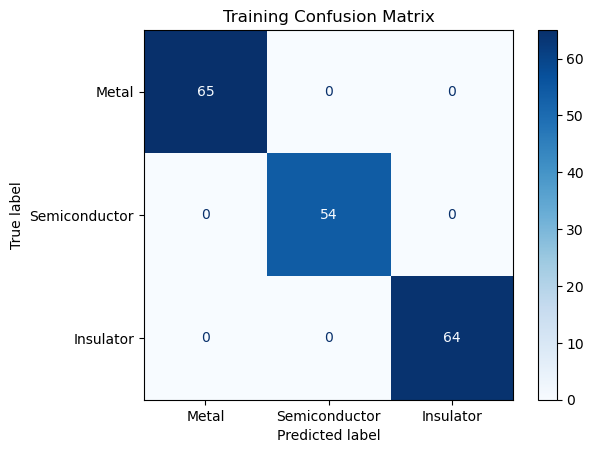

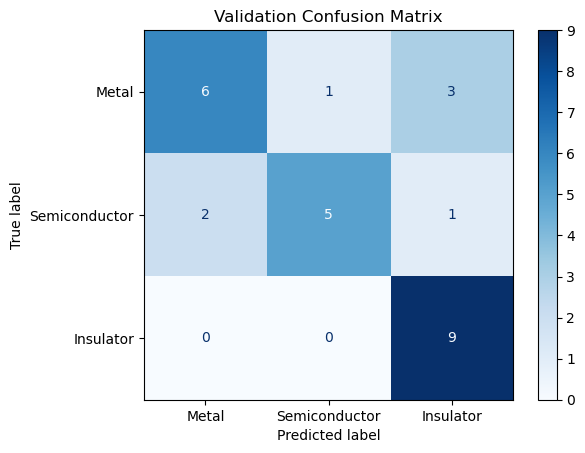

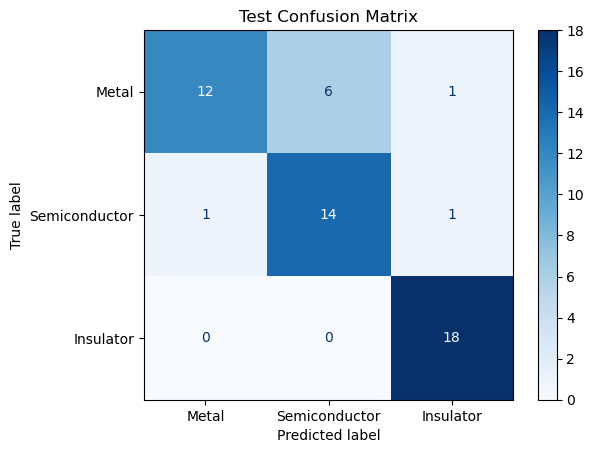

In [30]:
#  8. Confusion Matrix 
def plot_conf_matrix(y_true, y_pred, title):
    labels = ["Metal", "Semiconductor", "Insulator"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()
    
plot_conf_matrix(y_train, y_pred_train, "Training Confusion Matrix")
plot_conf_matrix(y_val, y_pred_val, "Validation Confusion Matrix")
plot_conf_matrix(y_test, y_pred_test, "Test Confusion Matrix")